Importing Neccessary Libraries

In [6]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random
import os
from math import isclose

from tabulate import tabulate
import itertools   
import matplotlib.image as mpImg 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import tree

from google.colab import drive


In [3]:
random.seed(42)

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#  <font color=slateblue>Problem 5</font> #

#### Node class - each leaf of the tree is a node 

In [7]:
class Node:
	def __init__(self, child = np.array([]), data = None, label = None, attributes = None):
		self.child = child
		self.data = data
		self.label = label
		self.attributes = attributes


In [8]:
def growNode(root, attribute, threshold):
  if(len(threshold[attribute]) == 2):
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] == threshold[attribute][1]]))], axis = 0)
    
  else:
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][1]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][2]]))], axis = 0)

#### Calculating entropy - $-p_+log_2^{p_+} - p_-log_2^{p_-}$

In [9]:
def entropy(targetNode):
    elements, counts = np.unique(targetNode, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy
    

#### Calculating Information Gain - $\text{entropy(S)} - \sum_V \frac{|S_v|}{|S|}\text{entropy}(S_v) $

In [10]:
def informationGain(root):
  totalEntropy = entropy(root.data.T[-1])
  reduction = np.sum([(child.data.shape[0] / root.data.shape[0]) * entropy(child.data.T[-1]) for child in root.child if not child.data.shape[0] == 0], axis = 0)
  gain = totalEntropy - reduction
  return gain


#### Finding best attribute - criteria : Information Gain

In [11]:
def findBestAttribute(root, threshold):
  information = np.array([])
  for attr in range(len(root.data[0]) - 1):
      tempNode = Node(data = root.data, label = root.label, attributes = root.attributes)
      growNode(tempNode, attr, threshold)
      information = np.append(information, [informationGain(tempNode)], axis=0)
      bestAttibute = np.argmax(information)
  return bestAttibute

#### Finding disjunctive attribute

In [12]:
def calculateThreshold(trainData):
  threshold = []
  for i in range(trainData.shape[1]):
      uniqueAttribute = np.unique(trainData[:, i])
      threshold.append(uniqueAttribute)
  return threshold

#### Making desicion tree - algorithm : ID3

In [13]:
def ID3(trainData, maxDepth, threshold):
  root = Node(data = trainData)

  if (root.data.T[-1].all() == True):
    root.label = 1
    return root
  if (root.data.T[-1].any() == False):
    root.label = 0
    return root
  if (maxDepth == 0):
    root.label = 1*((root.data.T[-1] == 1).sum() > (root.data.T[-1] == 0).sum())
    return root

  attribute = findBestAttribute(root, threshold)
  root.attributes = attribute
  if (len(threshold[attribute]) == 2):
    root.child = np.append(root.child, [ID3(np.array([data for data in trainData if data[attribute] == threshold[attribute][0]]), maxDepth-1, threshold)], axis = 0)
    root.child = np.append(root.child, [ID3(np.array([data for data in trainData if data[attribute] == threshold[attribute][1]]), maxDepth-1, threshold)], axis = 0)
  else:
    root.child = np.append(root.child, [ID3(np.array([data for data in trainData if data[attribute] == threshold[attribute][0]]), maxDepth-1, threshold)], axis = 0)
    root.child = np.append(root.child, [ID3(np.array([data for data in trainData if data[attribute] == threshold[attribute][1]]), maxDepth-1, threshold)], axis = 0)
    root.child = np.append(root.child, [ID3(np.array([data for data in trainData if data[attribute] == threshold[attribute][2]]), maxDepth-1, threshold)], axis = 0)
  return root

####Testing the trained tree


In [14]:
def moveAlongTree(testData, tree, threshold):
  if tree.label != None : return tree.label
  else:
    if len(threshold[tree.attributes]) == 2 :
      return moveAlongTree(testData, tree.child[0], threshold) if testData[tree.attributes] == threshold[tree.attributes][0] else moveAlongTree(testData, tree.child[1], threshold)
    else:
        if testData[tree.attributes] == threshold[tree.attributes][0]: return moveAlongTree(testData, tree.child[0], threshold)
        elif testData[tree.attributes] == threshold[tree.attributes][1]: return moveAlongTree(testData, tree.child[1], threshold)
        else: return moveAlongTree(testData, tree.child[2], threshold)



In [15]:
def testTrainedTree(trainData, testData, finalTree):
  return [moveAlongTree(testData[i], finalTree, threshold) for i in range(len(testData))]

#### Encoding data - turn strings to coded numbers

In [16]:
def encodeData(data, flag = 'library'):
  encodedData = []
  for i in range(11):
    if flag == 'library':
      labelEncoder = preprocessing.LabelEncoder()
      labelEncoder.fit(data.T[i])
      encodedData.append(labelEncoder.transform(data.T[i]))
    else:
      encodedData.append([dict([(y, x) for x, y in enumerate(sorted(set(data.T[i])))])[x] for x in data.T[i]])

  return np.array(encodedData)


Reading Dataset of Restaurant 

In [17]:
data = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/data.csv', 
                          header=None).to_numpy()
enc = encodeData(data).T[1:]
threshold = calculateThreshold(enc[1:])
maxDepth = 2
finalTree = ID3(enc[1:], maxDepth, threshold)
print(finalTree.attributes)
print(finalTree.child[0].attributes)
print(finalTree.child[1].attributes)
print(finalTree.child[2].attributes)

4
None
None
3


array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1])

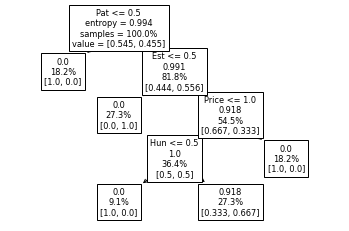

In [18]:
new = enc[1:]
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=7, max_leaf_nodes=5, splitter='best').fit(new[:,:-1], new[:,-1])
tree.plot_tree(clf, feature_names=['Alt','Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type', 'Est'], label='root', proportion=True) 
clf.predict(new[:,:-1])

#  <font color=slateblue>Problem 8</font> #

Reading Images

In [4]:
def imageLoader(folderPath):

  data, label = [], []

  for root, dirs, files in os.walk(folderPath):
    for file in files:
      face = mpImg.imread(os.path.join(root, file))
      face = face.reshape(256**2, ).tolist()
      data.append(face)
      label.append(file.split('.')[1])
  return np.asarray(data), label

In [69]:
folderPath = '/content/gdrive/My Drive/Colab Notebooks/HW/4/train'
trainData, trainLabels = imageLoader(folderPath)

folderPath = '/content/gdrive/My Drive/Colab Notebooks/HW/4/test'
testData, testLabels = imageLoader(folderPath)

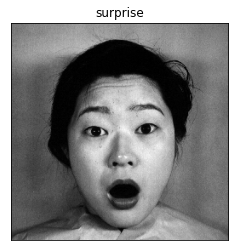

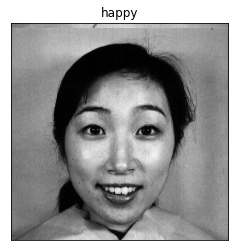

In [73]:
imageIndexs = random. sample(range(0, len(trainData)), 2)

for index in imageIndexs:
  plt.imshow(trainData[index].reshape(256,256), cmap='gray')
  plt.title(trainLabels[index])
  plt.xticks(())
  plt.yticks(())
  plt.show()


###  <font color=slateblue>Part A</font> ###

Plotting Eigenvales of PCA

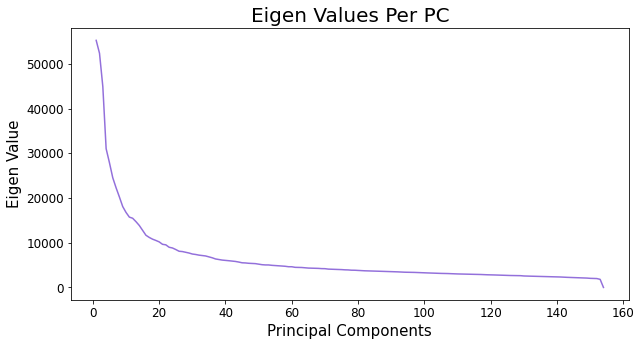

In [11]:
myPCA = PCA()
facesPC = myPCA.fit_transform(trainData)

plt.figure(figsize=(10,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.array(range(1,155)), myPCA.singular_values_, color='mediumpurple')
plt.xlabel('Principal Components',fontsize=15)
plt.ylabel('Eigen Value',fontsize=15)
plt.title("Eigen Values Per PC",fontsize=20)
plt.show()

Cumulative Sum

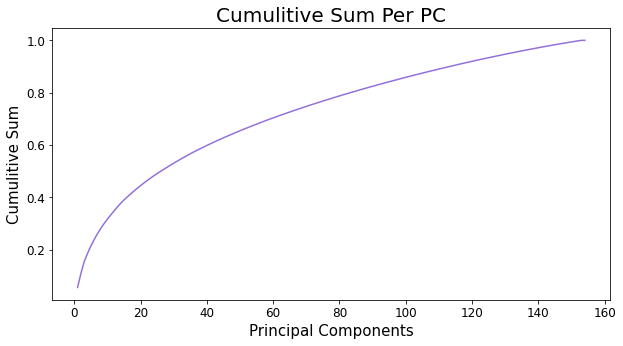

In [38]:
cumSumComp = np.cumsum(myPCA.singular_values_/np.sum(myPCA.singular_values_))

#Plotting Cumulitive Sum
plt.figure(figsize=(10,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.array(range(1,155)), cumSumComp, color='mediumpurple')
plt.xlabel('Principal Components',fontsize=15)
plt.ylabel('Cumulitive Sum',fontsize=15)
plt.title("Cumulitive Sum Per PC",fontsize=20)
plt.show()

In [37]:
PCs = [i for i in range(0,154) if isclose(cumSumComp[i], 0.9, abs_tol=1e-1) and isclose(cumSumComp[i], 0.90, abs_tol=1e-2) and isclose(cumSumComp[i], 0.900, abs_tol=1e-3)]
index = min(PCs)
print('Explained variation per principal component based on eigen values for the first ' + str(index)+ 
      ' PCs is %{:1.5}'.format(sum(myPCA.singular_values_[0:index])*100/sum(myPCA.singular_values_)))

Explained variation per principal component based on eigen values for the first 112 PCs is %89.654


###  <font color=slateblue>Part B</font> ###

Plot Table Beautifully :)

In [39]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

In [43]:
plotTable({1:['First Four Eigen Values'], 
                2:[myPCA.singular_values_[0]],
                3:[myPCA.singular_values_[1]],
                4:[myPCA.singular_values_[2]],
                5:[myPCA.singular_values_[3]]},
                [], 5)

plotTable({1:['Last Four Eigen Values'], 
                2:[myPCA.singular_values_[-1]],
                3:[myPCA.singular_values_[-2]],
                4:[myPCA.singular_values_[-3]],
                5:[myPCA.singular_values_[-4]]},
                [], 5)


╒═════════════════════════╤═════════╤═════════╤═════════╤═════════╕
│ First Four Eigen Values │ 55237.6 │ 52353.3 │ 44910.8 │ 31017.6 │
╘═════════════════════════╧═════════╧═════════╧═════════╧═════════╛
╒════════════════════════╤═══════════╤═════════╤═════════╤═════════╕
│ Last Four Eigen Values │ 2.664e-11 │ 1808.82 │ 1987.66 │ 2004.61 │
╘════════════════════════╧═══════════╧═════════╧═════════╧═════════╛


In [74]:
optPCA = PCA(n_components=112)
trainDataPC = optPCA.fit_transform(trainData)
testDataPC = optPCA.transform(testData)

myClsf1 = KNeighborsClassifier(n_neighbors=1)
myClsf1.fit(trainDataPC, trainLabels)
predLabels = myClsf1.predict(testDataPC)
acc1 = accuracy_score(testLabels, predLabels)*100


myClsf2 = KNeighborsClassifier(n_neighbors=2)
myClsf2.fit(trainDataPC, trainLabels)
predLabels = myClsf2.predict(testDataPC)
acc2 = accuracy_score(testLabels, predLabels)*100

plotTable({1:['Accuracy'], 
                2:[acc1],
                3:[acc2]},
                ['', 'k=1', 'k=2'], 3)

╒══════════╤═════════╤═════════╕
│          │   k=1   │   k=2   │
╞══════════╪═════════╪═════════╡
│ Accuracy │ 84.7458 │ 62.7119 │
╘══════════╧═════════╧═════════╛


#  <font color=slateblue>Problem 12</font> #

Plot Table Beautifully :)

In [45]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

Confusion Matrix:

In [46]:
def calcConfMat(testLabels, predLabels):
  
  classLabels = np.unique(testLabels)  
  return np.array([[np.sum((testLabels == classLabels[i]) & (predLabels == classLabels[j])) for j in range(len(classLabels))] for i in  range(len(classLabels))]) 

Plot Matrix

In [47]:
def plotConfMatrix(matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Purples):
    plt.figure(figsize = (5,5))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
  
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=10, fontweight='bold')
    plt.xlabel('Predicted Lables', fontsize=10, fontweight='bold')
    plt.show()

###  <font color=slateblue>Part A & B</font> ###

In [48]:
class ParzenWindow():
  def __init__(self, _method, _h, _prior=[1]*10):
    self.method = _method
    self.h = _h
    self.prior = _prior

  def gaussianKernel(self, data, featureSize):
    return 1/((2*np.pi)**(featureSize/2)) * np.exp(-0.5*((np.linalg.norm(data))**2))

  def gaussianPDF(self, sampleData, data):
    dataSize, featureSize = data.shape
    return (1/(dataSize * self.h**featureSize)) * sum([self.gaussianKernel((sampleData-data[i])/self.h,featureSize) for i in range(dataSize)])
  
  def rectKernel(self, data):
    return 0 if (np.linalg.norm(data)>0.5) else 1

  def rectPDF(self, sampleData, data):
    dataSize, featureSize = data.shape
    return (1/(dataSize * self.h**featureSize)) * sum([self.rectKernel((sampleData-data[i])/self.h) for i in range(dataSize)])

  def predDist(self, trainData, dataSample):
    if self.method == 'Rect':
      return np.array([self.prior[i] * self.rectPDF(dataSample, trainData[i]) for i in range(10)])
    elif self.method == 'Gaussian':
      return np.array([self.prior[i] * self.gaussianPDF(dataSample, trainData[i]) for i in range(10)])

  def predict(self, trainData, testData):
    return np.array([np.argmax(self.predDist(trainData, testData[i])) for i in range(len(testData))])


Reading Dataset

In [49]:
trainData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/trainData.csv', 
                          header=None)
trainLabels = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/trainLabels.csv',
                            header=None).values
testData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/testData.csv', 
                         header=None).values
testLabels = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/testLabels.csv', 
                           header=None).values

n, d = trainData.shape
trainData = [trainData[trainLabels==i].values for i in range(10)]  
prior = [trainData[i].shape[0]/n for i in range(10)]

Rectangular Window for 3 Values

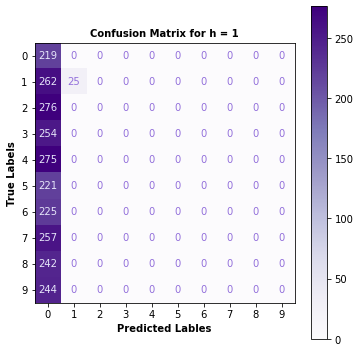

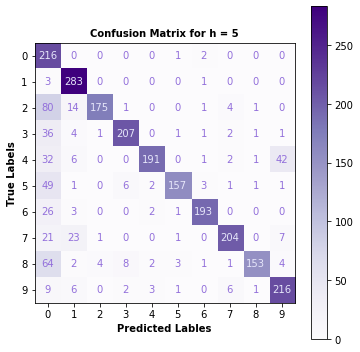

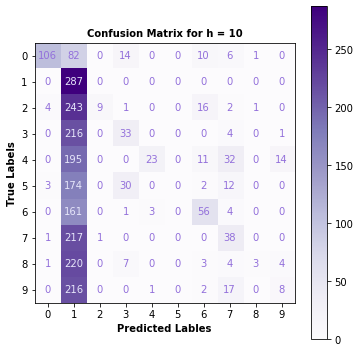

╒══════════╤═══════╤═══════╤════════╕
│          │  h=1  │  h=5  │  h=10  │
╞══════════╪═══════╪═══════╪════════╡
│ Accuracy │ 9.76  │ 79.8  │ 22.52  │
╘══════════╧═══════╧═══════╧════════╛


In [60]:
accuracy = []
classes = [str(i) for i in range(10)]

for h in [1, 5, 10]:
  myWindowEst = ParzenWindow(_method= 'Rect', _h=h, _prior=prior)
  predLabels = myWindowEst.predict(trainData, testData)
  matrix = calcConfMat(testLabels.flatten(), predLabels)
  plotConfMatrix(matrix, classes, title='Confusion Matrix for h = ' + str(h))
  accuracy.append((predLabels==testLabels.flatten()).mean()*100)
    
plotTable({1:['Accuracy'], 
                2:[accuracy[0]],
                3:[accuracy[1]],
                4:[accuracy[2]]},
                ['', 'h=1', 'h=5', 'h=10'], 4)

Gaussian Window for 3 Values

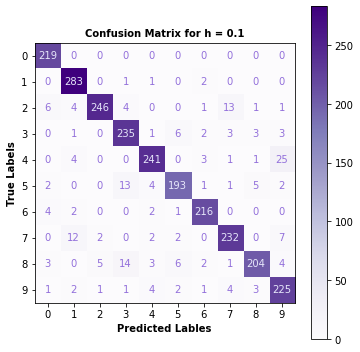

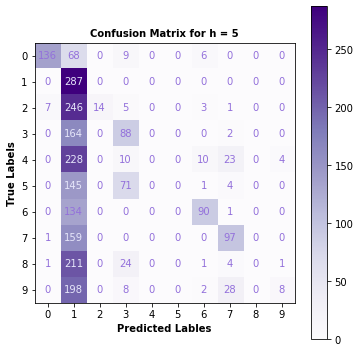

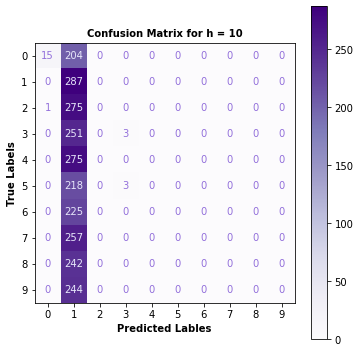

╒══════════╤═════════╤═══════╤════════╕
│          │  h=0.1  │  h=5  │  h=10  │
╞══════════╪═════════╪═══════╪════════╡
│ Accuracy │  91.76  │ 28.8  │  12.2  │
╘══════════╧═════════╧═══════╧════════╛


In [61]:
accuracy = []
classes = [str(i) for i in range(10)]

for h in [0.1, 5, 10]:
  myWindowEst = ParzenWindow(_method= 'Gaussian', _h=h, _prior=prior)
  predLabels = myWindowEst.predict(trainData, testData)
  matrix = calcConfMat(testLabels.flatten(), predLabels)
  plotConfMatrix(matrix, classes, title='Confusion Matrix for h = ' + str(h))
  accuracy.append((predLabels==testLabels.flatten()).mean()*100)

plotTable({1:['Accuracy'], 
                2:[accuracy[0]],
                3:[accuracy[1]],
                4:[accuracy[2]]},
                ['', 'h=0.1', 'h=5', 'h=10'], 4)

#  <font color=slateblue>Problem 13</font> #

Plot Table Beautifully :)

In [54]:
def plotTable(clms, clmDataHeadears, alignSize):
    data = []
    
    for i in range(len(clms[list(clms.keys())[0]])):
        dataElement = []
        for key in clms.keys():
            dataElement.append(clms[key][i])
        data.append(dataElement)
        
    print(tabulate(data, headers=clmDataHeadears, tablefmt="fancy_grid", 
                   colalign=["center"]*alignSize))

Confusion Matrix:

In [55]:
def calcConfMat(testLabels, predLabels):
  
  classLabels = np.unique(testLabels)  
  return np.array([[np.sum((testLabels == classLabels[i]) & (predLabels == classLabels[j])) for j in range(len(classLabels))] for i in  range(len(classLabels))]) 

Plot Matrix

In [56]:
def plotConfMatrix(matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Purples):
    plt.figure(figsize = (5,5))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=10, fontweight='bold')
    plt.xlabel('Predicted Lables', fontsize=10, fontweight='bold')
    plt.show()

###  <font color=slateblue>Part A</font> ###

In [57]:
class KNN():
  def __init__(self, _k, _featureSize, _prior=[0.1]*10):
    self.k = _k
    self.prior = np.array(_prior)
    self.featureSize = _featureSize

  def calcDist(self, dataSample, data):
    distance = sorted([np.linalg.norm(dataSample-item) for item in data])[self.k-1]
    return self.k/(len(data)*(distance**self.featureSize))

  def predDist(self, trainData, dataSample):
    return np.array([self.prior[i] * self.calcDist(dataSample, trainData[i]) for i in range(10)])

  def predict(self, trainData, testData):
    return np.array([np.argmax(self.predDist(trainData, testData[i])) for i in range(len(testData))])


Reading Dataset

In [58]:
trainData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/trainData.csv', 
                          header=None)
trainLabels = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/trainLabels.csv',
                            header=None).values
testData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/testData.csv', 
                         header=None).values
testLabels = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/HW/4/TinyMNIST/testLabels.csv', 
                           header=None).values

n, d = trainData.shape
trainData = [trainData[trainLabels==i].values for i in range(10)]  
prior = [trainData[i].shape[0]/n for i in range(10)]

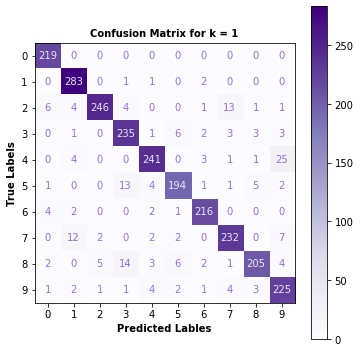

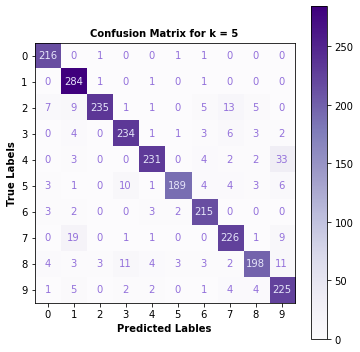

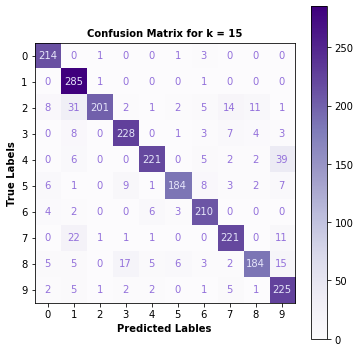

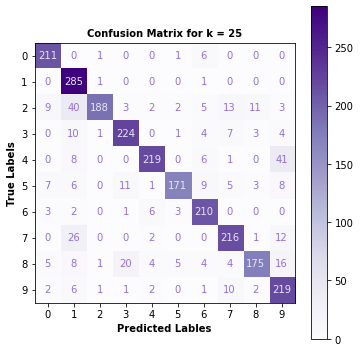

╒══════════╤═══════╤═══════╤════════╤════════╕
│          │  k=1  │  k=5  │  k=15  │  k=25  │
╞══════════╪═══════╪═══════╪════════╪════════╡
│ Accuracy │ 91.84 │ 90.12 │ 86.92  │ 84.72  │
╘══════════╧═══════╧═══════╧════════╧════════╛


In [62]:
accuracy = []
classes = [str(i) for i in range(10)]

for k in [1, 5, 15, 25]:
  myWindowEst = KNN(_k=k, _featureSize=d, _prior=prior)
  predLabels = myWindowEst.predict(trainData, testData)
  matrix = calcConfMat(testLabels.flatten(), predLabels)
  plotConfMatrix(matrix, classes, title='Confusion Matrix for k = ' + str(k))
  accuracy.append((predLabels==testLabels.flatten()).mean()*100)

plotTable({1:['Accuracy'], 
                2:[accuracy[0]],
                3:[accuracy[1]],
                4:[accuracy[2]],
                5:[accuracy[3]]},
                ['', 'k=1', 'k=5', 'k=15', 'k=25'], 5)